In [1]:
import keras
import xmltodict
import os
import typing
import re
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import math
import numpy as np
import cv2
import json
from pathlib import Path

Using TensorFlow backend.


In [2]:
#import all libraries
from PIL import Image, ImageOps,ImageFilter
#import cv2
import time
import argparse
from scipy import ndimage
from scipy import misc
%matplotlib inline
import readline
readline.parse_and_bind("tab: complete")
from scipy import ndimage
from multiprocessing.pool import ThreadPool

from urllib.request import Request, urlopen, HTTPError
import ssl

In [3]:
#Image processing for resizing images
def fix_aspect_ratio(img,expected_dimension):
    original_max_dim = max(float(img.size[0]),float(img.size[1]))
    original_min_dim = min(float(img.size[0]),float(img.size[1]))
    wpercent = (expected_dimension/float(original_max_dim))
    hsize = int((original_min_dim*float(wpercent)))
    new_im = img.resize((expected_dimension,hsize), Image.ANTIALIAS)
    return new_im

In [4]:
# Make square images
def make_square(img, min_size=120, fill_color=(0, 0, 0, 0)):
    x, y = img.size
    size = max(min_size, x, y)
    new_im = Image.new('RGBA', (size, size), fill_color)
    new_im.paste(img, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

In [5]:
# Sharpen the edges
from pylab import *
def sharpen_filter(img):
    sharp_im = img.filter(ImageFilter.SHARPEN)
    return sharp_im

In [6]:
def strings_to_numbers(argument): 
    switcher = { 
        "audi-symbol": 0, 
        "bmw": 1, 
        "toyota":2,
        "hyundai-symbol":3,
        "mercedes":4,
        "ford-symbol":5,
        "honda-symbol":6,
        "fiat":7,
        "ferrari":8,
         "nissan-symbol":9,
        "porsche":10,
        "chevrolet-symbol": 11 , 
        "volvo":12,
    } 
  
    # get() method of dictionary data type returns  
    # value of passed argument if it is present  
    # in dictionary otherwise second argument will 
    # be assigned as default value of passed argument 
    return switcher.get(argument, 100) 

In [28]:
# Load dataset of logos in a dataframe
def get_logos_df(glob_path,dir_litw_resized,folder,size_threshold):
    df_logos = pd.DataFrame(columns=['true_logo','logo_img_name','original_image_name','logo_img_path','company_brand','brand_count','X_size','Y_size'])
     # in each folder, find image file and resize-scale them without distortion
    index_image= 1;
    expected_dimension=120
    image_numbers = 200
    
    #image_array = np.ndarray((image_numbers,120,120,3),dtype=np.uint8)
    glob_path_complete = os.path.join(glob_path,folder)
    
    files = [f_img_name for f_img_name in glob.glob(glob_path_complete + "**/*.jpg", recursive=True)]
    print(len(files))
    
    mod_folder_name = 'Mod-' + str(folder)
    mod_full_dir = os.path.join(dir_litw_resized,mod_folder_name) 
    brand_count_row=1
    for filename in files:
         with open(filename) as imagefile:
            
            head, tail = os.path.split(filename)            
            orig_img = os.path.join(glob_path_complete,tail)            
            img_mod_name = folder +'-AB-'+ str(index_image) +'.png'
            
            os.makedirs(mod_full_dir, exist_ok=True)
            path_to_image = os.path.join(mod_full_dir,img_mod_name)
            
            
            company_brand_name = folder
            image_original = Image.open(orig_img)
            get_file_data_shape_x, get_file_data_shape_y = image_original.size
            max_size_dimension = max(float(get_file_data_shape_x),float(get_file_data_shape_y))
            if max_size_dimension < size_threshold:
                continue
            image_aspect=fix_aspect_ratio(image_original,expected_dimension)
            
            img_new = make_square(image_aspect)
            
            sharpen_image=sharpen_filter(img_new)
            im_med = ndimage.median_filter(sharpen_image, 3)
            
            switcher_output =strings_to_numbers(folder)
            
            row = pd.Series({'true_logo' :switcher_output,
                            'logo_img_name' :img_mod_name,
                             'original_image_name' :orig_img,
                             'logo_img_path' :path_to_image,
                             'company_brand' :folder,
                             'brand_count' :brand_count_row,
                             'X_size' :get_file_data_shape_x,
                             'Y_size' :get_file_data_shape_y,})
            df_logos = df_logos.append(row,ignore_index=True)            
            brand_count_row=brand_count_row+1
            file_name=os.path.join(mod_full_dir,img_mod_name)
            misc.imsave(file_name, im_med)
            index_image =index_image+1                 
    return df_logos     
           
        

In [29]:
# Prepare the logos dataset datastructure
# Set threshold for the size of the logo images to avoid heavy distortion due to resize
def get_all_images():
    dir_litw=Path("c:/Users/Sanyogita/Documents/Insight/projects/Trademark_RADAR/data/")
    dir_litw_resized=Path("c:/Users/Sanyogita/Documents/Insight/projects/Trademark_RADAR/resized_data")
    df_list=[]
    
    for folder in sorted(os.listdir(dir_litw), key=str.casefold):
        glob_path_complete = os.path.join(dir_litw,folder)
        
        files = [f_img_name for f_img_name in glob.glob(glob_path_complete + "**/*.jpg", recursive=True)]
    #if len(files) < 99:=
        #continue  
        size_threshold=0
        df_list.append(get_logos_df(dir_litw,dir_litw_resized,folder,size_threshold))
    
        tp_df = pd.concat(df_list, ignore_index=True)      
        
    return tp_df

In [30]:
# Get the count of images in each brand
def Get_brand_img_count(threshold_count):
    # Plotn the graphs for demo
    tp_df=get_all_images()
    print(str(tp_df.shape))
    print("X median",str(tp_df['X_size'].median()))
    print("X mean",str(tp_df['X_size'].mean()))

    print("Y median",str(tp_df['Y_size'].median()))
    print("Y mean",str(tp_df['Y_size'].mean()))
    tp_group_by=tp_df.groupby('company_brand').size().plot(kind='bar',color='green')
    plt.show()
    # Get image counts per brand
    tp_group_by_stage1=tp_df.groupby('company_brand').size()
    fp_series = pd.Series(tp_df['company_brand']).value_counts()
    plt.figure(figsize=(15, 5))
    fp_series[fp_series > threshold_count].plot.bar(color='limegreen')
    fp_series[fp_series > threshold_count].head()
    plt.rcParams.update({'font.size': 18})
    Count_brand_logos=(fp_series.values)
    print((Count_brand_logos))
    
    return Count_brand_logos, tp_df

227


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


222
44
2
11
37
99
309
167
100
14
214
9
(1455, 8)
X median 28.0
X mean 45.59106529209622
Y median 21.0
Y mean 33.50790378006873


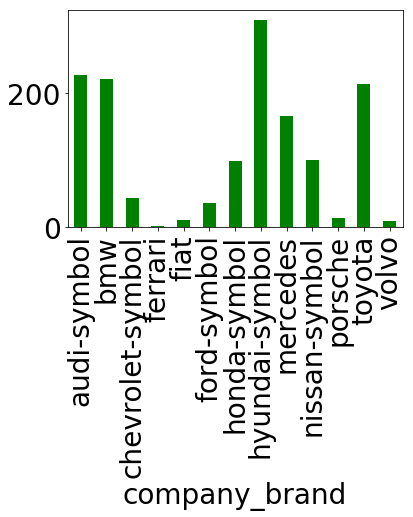

[309 227 222 214 167 100  99  44  37  14  11   9   2]


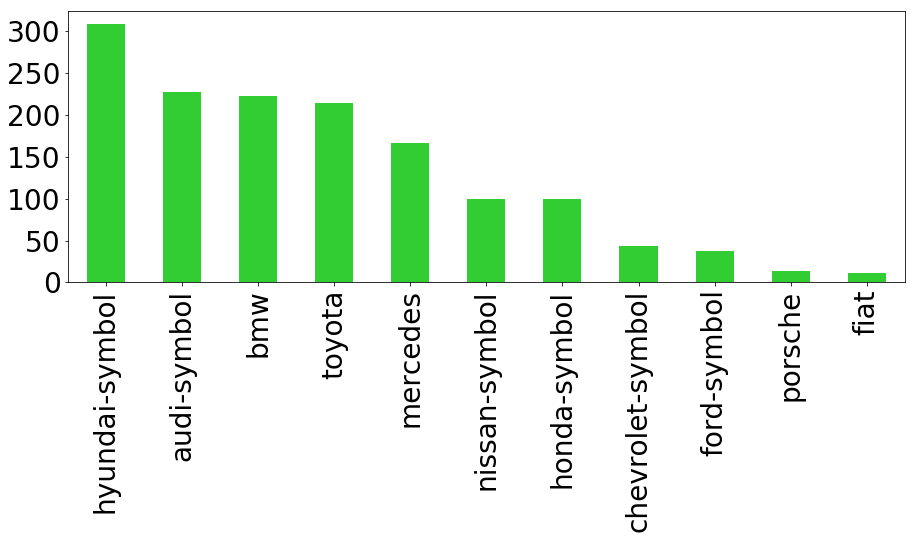

In [31]:
# Call counting and plotting functions for gathering dataset information
[Count_brand_logos,tp_df] = Get_brand_img_count(10)


In [32]:
# Filter images from the dataset and select brands with larger number of images
def create_matrix(df, *company_names):
    
    df_filtered=df[df['company_brand'].isin(company_names)]
       
    return df_filtered

In [33]:
# get all brand images that are resizes, processed. these brands have sufficient data for training
df_filtered=create_matrix(tp_df,'hyundai-symbol','audi-symbol','bmw','toyota') #Remove Honda and Nissan labels
df_filtered.head()


,true_logo,logo_img_name,original_image_name,logo_img_path,company_brand,brand_count,X_size,Y_size
0,0,audi-symbol-AB-1.png,c:\Users\Sanyogita\Documents\Insight\projects\...,c:\Users\Sanyogita\Documents\Insight\projects\...,audi-symbol,1,31,13
1,0,audi-symbol-AB-2.png,c:\Users\Sanyogita\Documents\Insight\projects\...,c:\Users\Sanyogita\Documents\Insight\projects\...,audi-symbol,2,85,45
2,0,audi-symbol-AB-3.png,c:\Users\Sanyogita\Documents\Insight\projects\...,c:\Users\Sanyogita\Documents\Insight\projects\...,audi-symbol,3,13,9
3,0,audi-symbol-AB-4.png,c:\Users\Sanyogita\Documents\Insight\projects\...,c:\Users\Sanyogita\Documents\Insight\projects\...,audi-symbol,4,146,72
4,0,audi-symbol-AB-5.png,c:\Users\Sanyogita\Documents\Insight\projects\...,c:\Users\Sanyogita\Documents\Insight\projects\...,audi-symbol,5,23,10


In [34]:
# select few samples from the company brands to evaluate the feasibility of the co-occurrence matrix
# Output: Input images X and their labels y
from skimage.feature import greycomatrix, greycoprops
from skimage import data,io
import matplotlib.image as mpimg

def Get_initial_data(df_filtered,Count_brand_logos):
    xs = []
    ys = []
    
    img_num = len(df_filtered) # number of distinct brands*num_of images_each_brand base don the threshold
    print(img_num)
    defect_imgs = np.ndarray((img_num, 120, 120), dtype=np.uint8)
    y = np.array(df_filtered['true_logo'],dtype=int)
    index = 0

    for index_df, record in df_filtered.iterrows():
        x = io.imread(record['logo_img_path'])
        red = x[:,:,2]
        green = x[:,:,1]
        blue = x[:,:,0]
        image_2D = x[:,:,3]
        
        #glcm = greycomatrix(nir,  [5], [0, np.pi/4, np.pi/2], levels=256, normed=True, symmetric=True)
        glcm = greycomatrix(image_2D,[2], [0], levels=256, symmetric=True, normed=True)
        xs.append(greycoprops(glcm, 'correlation')[0, 0])
        ys.append(greycoprops(glcm, 'dissimilarity')[0, 0])
        index += 1
        X = defect_imgs        

    fig = plt.figure(figsize=(8, 8)) 
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(xs[:Count_brand_logos[0]], ys[:Count_brand_logos[0]], 'go',
        label='audi')
    ax.plot(xs[:Count_brand_logos[1]], ys[:Count_brand_logos[1]], 'bo',
        label='toyota')
    ax.plot(xs[:Count_brand_logos[2]], ys[:Count_brand_logos[2]], 'rs',
        label='mercedes')
    ax.set_xlabel('GLCM correlation',fontsize=28)
    ax.set_ylabel('GLCM dissimilarity',fontsize=28)
    ax.legend()
    plt.setp(plt.gca().get_legend().get_texts(), fontsize='20') 
    plt.rcParams.update({'font.size': 28})
    return X,y    

972


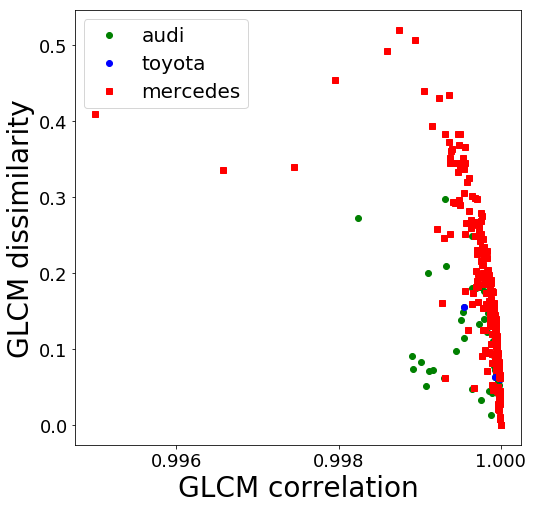

In [35]:
#Get all the images and labels
#Plot the similarity matrix
X,y = Get_initial_data(df_filtered,Count_brand_logos)

In [36]:
def Get_train_test_matrix(df_image_total,min_range_count,max_range_count):
    df_filtered = df_image_total[(df_image_total.brand_count.between(left=min_range_count, right=max_range_count,inclusive = True))]
    
    # y will be the label: true logos will be given a value base don the category
    y = np.array(df_filtered['true_logo'])
    logo_img_num = len(df_filtered)
    print(logo_img_num)
    logo_imgs = np.ndarray((logo_img_num, 120, 120, 3), dtype=np.uint8)

    index = 0
    for index_df, record in df_filtered.iterrows():
        
        # retrieve the image and feed it into mpimg.imread
        img_get = mpimg.imread(record['logo_img_path'])
        normalizedImg = cv2.normalize(img_get,None,0,1, cv2.NORM_MINMAX)
        logo_imgs[index] = normalizedImg[:,:,:3]
        index += 1
    
    X = logo_imgs
    
    return X, y


In [62]:
x_train,y_train = Get_train_test_matrix(df_filtered,1,171)
x_valid,y_valid = Get_train_test_matrix(df_filtered,172,193)
x_test,y_test = Get_train_test_matrix(df_filtered,194,214)


684
88
84


In [63]:
from keras.applications.inception_v3 import InceptionV3
#from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, nadam
from keras import backend as K
from keras.utils import to_categorical
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

In [64]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=2)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
#x = Dropout(0.1)(x)
predictions_layer = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions_layer)
for layer in base_model.layers:
    layer.trainable = True
    


In [67]:
model.summary()
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_283 (Conv2D)             (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_283 (BatchN (None, None, None, 3 96          conv2d_283[0][0]                 
__________________________________________________________________________________________________
activation_283 (Activation)     (None, None, None, 3 0           batch_normalization_283[0][0]    
__________________________________________________________________________________________________
conv2d_284

In [68]:
y_binary_train = to_categorical(y_train)
y_binary_valid = to_categorical(y_valid)
y_binary_test=to_categorical(y_test)
model.fit((x_train), y_binary_train, shuffle=True, validation_data=((x_valid), y_binary_valid), 
          batch_size=50, epochs=50, verbose=1, callbacks=[early_stopping])

Train on 684 samples, validate on 88 samples
Epoch 1/50
684/684 [==============================] - 125s 183ms/step - loss: 1.0807 - acc: 0.5877 - val_loss: 1.0194 - val_acc: 0.5682
Epoch 2/50
684/684 [==============================] - 93s 136ms/step - loss: 0.6861 - acc: 0.7558 - val_loss: 0.9756 - val_acc: 0.5341
Epoch 3/50
684/684 [==============================] - 88s 129ms/step - loss: 0.4732 - acc: 0.8114 - val_loss: 0.8210 - val_acc: 0.6477
Epoch 4/50
684/684 [==============================] - 87s 128ms/step - loss: 0.3596 - acc: 0.8640 - val_loss: 0.7828 - val_acc: 0.7159
Epoch 5/50
684/684 [==============================] - 88s 129ms/step - loss: 0.3092 - acc: 0.8772 - val_loss: 0.8171 - val_acc: 0.6932
Epoch 6/50
684/684 [==============================] - 88s 128ms/step - loss: 0.2799 - acc: 0.8830 - val_loss: 0.8042 - val_acc: 0.6818
Epoch 7/50
684/684 [==============================] - 90s 132ms/step - loss: 0.2642 - acc: 0.8889 - val_loss: 0.8904 - val_acc: 0.7045
Epoch 000

In [71]:
def print_predict_convert():

    predict_test_results = model.predict(x_test)
    
    predict_test_results


    # calculate accuracy
    y_predict = np.argmax(predict_test_results, axis=1)


    print(y_test)
    print(y_predict)



    y_test_1=np.array(y_test.astype(int64))
    print(type(y_test_1))
    
    return(predict_test_results,y_test,y_test_1,y_predict)    

In [72]:
[predict_test_results,y_test,y_test_1,y_predict] = print_predict_convert()

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 3 2 0 0 0 0 0 0 0 0 3 1 1 1 1 1 2 0 0 0 1 1 1 3 1 1
 1 1 0 1 3 3 2 3 3 3 3 3 2 3 0 0 3 2 2 2 3 2 2 0 3 3 0 2 2 0 1 0 0 0 0 0 2
 1 2 0 2 2 2 2 0 0 0]
<class 'numpy.ndarray'>


[[19  0  1  1]
 [ 4 13  1  3]
 [11  2  8  0]
 [ 3  0  7 11]]


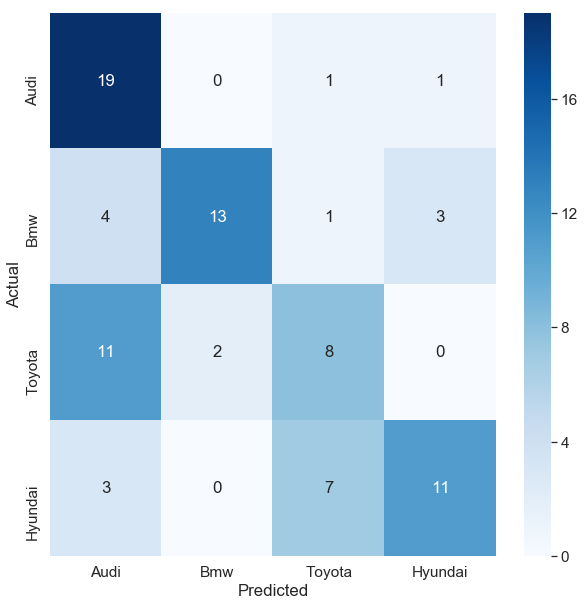

In [73]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve



cm = confusion_matrix(y_test_1, y_predict)
print(cm)


import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
#plt.rcParams.update({'font.size': 28})
sns.set(font_scale=1.4)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['Audi','Bmw','Toyota','Hyundai'], yticklabels=['Audi','Bmw','Toyota','Hyundai'],cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [75]:
import sys
sys.getdefaultencoding()

'utf-8'

In [76]:
from keras.models import load_model
from joblib import dump, load
import pickle

def save_model(model):
    s = pickle.dumps(model)
    dump(model, 'filename_5.joblib')

    model = load('filename_5.joblib') 

    intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer('dense_11').output)
    #predict to get featured data
    feauture_engg_data = intermediate_layer_model.predict(x_test)
    feauture_engg_data = pd.DataFrame(feauture_engg_data)
    print('feauture_engg_data shape:', feauture_engg_data.shape)


In [ ]:
save_model(model)

In [ ]:
#save_model()


clf = load('filename_5.joblib') 
y_predict= clf.predict(x_test)


In [ ]:
from sklearn.metrics import confusion_matrix
y_test_1=np.array(y_test.astype(int64))
print(type(y_test_1))

y_predict_1= clf.predict(x_test)

y_predict_3 = np.argmax(y_predict_1, axis=1)

clf.summary()
cm = confusion_matrix(y_test_1, y_predict_3)
print(cm)
from sklearn.metrics import average_precision_score
average_precision_score(y_test_1, y_predict_3) 

In [ ]:
# Defining the Generator network

def get_generator(optimizer):
    
    generator = Sequential()
    generator.add(Dense(64, input_dim=num_features, kernel_initializer=initializers.glorot_normal(seed=42)))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(128))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
       
    generator.add(Dense(512))
    generator.add(Activation('tanh'))
   
    generator.add(Dense(num_features, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return generator

In [ ]:
#Defining the Discriminator network

def get_discriminator(optimizer):
    
    discriminator = Sequential()
    
    discriminator.add(Dense(256, input_dim=num_features, kernel_initializer=initializers.glorot_normal(seed=42)))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
       
    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(1))
    discriminator.add(Activation('sigmoid'))
   
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return discriminator

In [ ]:
num_features = df_filtered.shape[0]
def get_gan_network(discriminator, generator, optimizer,input_dim=num_features):

    discriminator.trainable = False   
    
    gan_input = Input(shape=(input_dim,))  
    
    x = generator(gan_input)        
    gan_output = discriminator(x)
    
    gan = Model(inputs=gan_input, outputs=gan_output)    
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return gan

In [ ]:
print(num_features)

learning_rate = 0.00001
batch_size = 512
epochs = 10
adam = Adam(lr = learning_rate,beta_1 = 0.5)

In [ ]:
import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
import SimpleITK as sitk
from IPython import display
from IPython.display import Image
